In [1]:
!pip uninstall dataclasses -y
!pip install pingouin

Found existing installation: dataclasses 0.6
Uninstalling dataclasses-0.6:
  Successfully uninstalled dataclasses-0.6
     |████████████████████████████████| 205 kB 1.3 MB/s eta 0:00:01
  Created wheel for pingouin: filename=pingouin-0.3.12-py3-none-any.whl size=204286 sha256=d513bd8721fce02e7a14bb69d7c62357006f55e9d632530e984985909e034298
  Stored in directory: /root/.cache/pip/wheels/5b/8a/ed/fafe2714a0f047d64fb582105b174b5e5218c82a0d787bbec4
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=6b92cdd006f3ea551bab7cb7d20c6b5a3117c08dcb2a89660f94133c5e214cac
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils


In [332]:
import os
import warnings
from collections import Counter
from itertools import chain, product
from time import time

# import cudf
# import cupy
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import torch
# from cuml.ensemble import RandomForestClassifier
# from cuml.linear_model import LogisticRegression
# from cuml.manifold import TSNE, UMAP
# from cuml.svm import SVC
from lightgbm import LGBMClassifier
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
from sklearn.metrics import (auc, classification_report, roc_auc_score, confusion_matrix,
                             roc_curve)
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder,
                                   MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer,
                                   StandardScaler)
from sklearn.tree import DecisionTreeClassifier
from torch import nn
from torch.utils.data import DataLoader
# import pingouin as pg
from torch.utils.data.dataset import Dataset

from ray import tune

warnings.filterwarnings('ignore')


In [2]:
print(plt.style.available)
plt.style.use('tableau-colorblind10')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [114]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

In [298]:
application_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
application_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

In [299]:
target_id = application_test['SK_ID_CURR'].values

y = application_train['TARGET']
app_full = pd.concat([application_train.drop(['TARGET'], axis=1) ,application_test])

In [229]:
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """Generate missing values report

    Args:
        df (pd.DataFrame): DataFrame

    Returns:
        pd.DataFrame: Missing values report
    """
    mis_val = df.isnull().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns

def get_iqr(col: pd.Series, lower_bound=0.05, upper_bound=0.95) -> tuple:
    lower = col.quantile(lower_bound)
    upper = col.quantile(upper_bound)
    return lower, upper


def fill_oulier_with_na(col: pd.Series,
                        lower_bound=0.05,
                        upper_bound=0.95):
    lower, upper = get_iqr(col, lower_bound, upper_bound)

    def replace(val):
        if val > upper or val < lower:
            return np.nan
        return val

    return col.apply(replace)

def replacer(column: pd.Series, imputer: SimpleImputer):
    return imputer.fit_transform(column)


def fill_na(df: pd.DataFrame, replacer: None):
    return df.apply(replacer, axis=1)

# EDA

Xem xét phân phối của các trường dữ liệu thuộc mỗi nhóm

In [166]:
application_no_na = application_train.dropna(axis=0)
application_no_na = application_no_na.applymap(lambda x: 0 if pd.isna(x) else x)
application_no_na = application_no_na.drop(["SK_ID_CURR"], axis=1)

target_ID = application_test['SK_ID_CURR']

target_0 = application_no_na[application_no_na['TARGET']==0].drop("TARGET", axis=1)
target_1 = application_no_na[application_no_na['TARGET']==1].drop("TARGET", axis=1)

application_no_na.shape

obj_cols = target_0.dtypes[target_0.dtypes=='object']
unq_data_0 = target_0[obj_cols.index].nunique()
unq_data_1 = target_1[obj_cols.index].nunique()

cols_encode_with_labelencoder = unq_data_0[unq_data_0<=2].index
cols_encode_with_onehotencoder = unq_data_0[unq_data_0>2].index

for col in cols_encode_with_labelencoder:
    label_encoder.fit(target_0[col])
    target_0[col] = label_encoder.transform(target_0[col])
    target_1[col] = label_encoder.transform(target_1[col])

for col in cols_encode_with_onehotencoder:
    onehot_encoder.fit(target_0[col].to_numpy().reshape(-1, 1))
    columns = list(
        map(lambda x: f"{col}_{x.upper()}", onehot_encoder.get_feature_names()))
    temp_0 = pd.DataFrame(onehot_encoder.transform(
        target_0[col].to_numpy().reshape(-1, 1)),
                          columns=columns)
    temp_1 = pd.DataFrame(onehot_encoder.transform(
        target_1[col].to_numpy().reshape(-1, 1)),
                          columns=columns)

    #     target_0 = target_0.drop([col], axis=1)
    #     target_1 = target_1.drop([col], axis=1)
    target_0 = pd.concat([target_0, temp_0], axis=1)
    target_1 = pd.concat([target_1, temp_1], axis=1)

X0 = target_0.to_numpy()
X1 = target_1.to_numpy()

# X0 = np.log1p(X0)
# X1 = np.log1p(X1)

X0.shape

(84227, 250)

## Kiểm tra các dữ liệu bị thiếu

(17, 2)

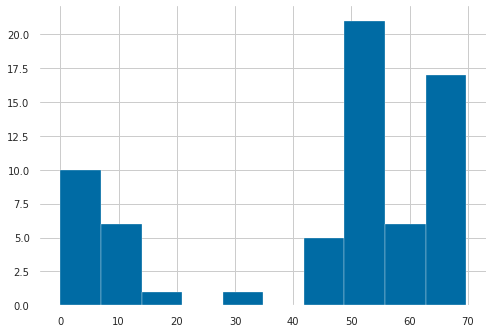

In [300]:
missing_cols = missing_values_table(app_full)

missing_cols['% of Total Values'].hist()
missing_cols[missing_cols['% of Total Values']>60].shape

Hình trên cho thấy tỉ lệ dữ liệu bị thiếu trong các cột, cơ bản có thể thấy ngưỡng 35 - 45%.

Có thể xem xét ngưỡng 35% làm ngưỡng để loại bỏ cột đó khỏi dữ liệu. Chỉ sử dụng các cột đầy đủ, hoặc thiếu dưới 35%

In [ ]:
plt.figure(figsize = (20, 15))
sns.barplot(data = missing_cols, y = missing_cols.index, x = '% of Total Values')
plt.xticks(ticks = None)
# plt.savefig('missing_cols.png')

In [301]:
threshold = 100

missing_col_above_threshold = missing_cols[missing_cols['% of Total Values']>threshold]
missing_col_above_threshold

,Missing Values,% of Total Values


In [217]:
print(missing_col_above_threshold)

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [278]:
app_full.shape

(356255, 120)

In [279]:
application_train.shape

(307511, 121)

In [280]:
application_test.shape

(48744, 120)

In [302]:
# Drop các cột có số lượng missing values lớn hơn threshold
try:
    application_train = application_train.drop(missing_col_above_threshold.index, axis=1)
    application_test = application_test.drop(missing_col_above_threshold.index, axis=1)
    app_full = app_full.drop(missing_col_above_threshold.index, axis=1)
except:
    pass

try:
    application_train = application_train.drop(['SK_ID_CURR'], axis=1)
    app_full = app_full.drop(['SK_ID_CURR'], axis=1)
    application_test = application_test.drop(['SK_ID_CURR'], axis=1)
except:
    pass

In [ ]:
application_train.shape

In [ ]:
application_test.describe()

In [169]:
y = y.astype(int)

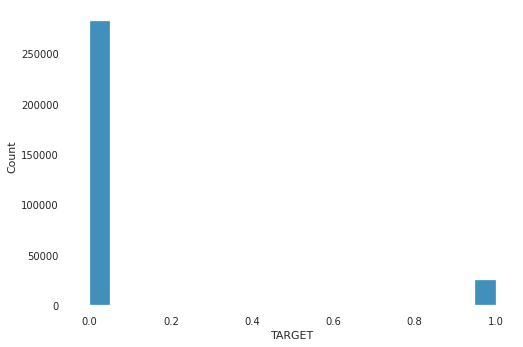

In [170]:
sns.histplot(y)
plt.savefig('label-proportion.png')

In [303]:
application_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [ ]:
plt.figure(figsize=(16, 16))

mask = np.triu(np.ones_like(application_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(application_train.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

plt.savefig('numerical_corr.png')

In [281]:
def fill_0(x):
    return 0 if x>0 else np.abs(x)

In [245]:
# Biến đổi một số thuộc tính

application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH']/-365
application_train['DAYS_EMPLOYED'] = -fill_oulier_with_na(application_train['DAYS_EMPLOYED'], 0.05, 0.75)
application_train['DAYS_EMPLOYED_BIRTH_RATIO'] = application_train['DAYS_EMPLOYED']/application_train['DAYS_BIRTH']
application_train['DAYS_REGISTRATION'] = application_train['DAYS_REGISTRATION'].apply(fill_0)
application_train['DAYS_ID_PUBLISH'] = application_train['DAYS_ID_PUBLISH'].apply(fill_0)
application_train['DAYS_LAST_PHONE_CHANGE'] =application_train['DAYS_LAST_PHONE_CHANGE'].apply(fill_0)

In [175]:
application_test['DAYS_BIRTH'] = application_test['DAYS_BIRTH']/-365
application_test['DAYS_EMPLOYED'] = -fill_oulier_with_na(application_test['DAYS_EMPLOYED'], 0.05, 0.75)
application_test['DAYS_EMPLOYED_BIRTH_RATIO'] = application_test['DAYS_EMPLOYED']/application_test['DAYS_BIRTH']
application_test['DAYS_REGISTRATION'] = application_test['DAYS_REGISTRATION'].apply(fill_0)
application_test['DAYS_ID_PUBLISH'] = application_test['DAYS_ID_PUBLISH'].apply(fill_0)
application_train['DAYS_LAST_PHONE_CHANGE'] =application_train['DAYS_LAST_PHONE_CHANGE'].apply(fill_0)

In [305]:
app_full['DAYS_BIRTH'] = app_full['DAYS_BIRTH']/-365
app_full['DAYS_EMPLOYED'] = -fill_oulier_with_na(app_full['DAYS_EMPLOYED'], 0.05, 0.75)
app_full['DAYS_EMPLOYED_BIRTH_RATIO'] = app_full['DAYS_EMPLOYED']/app_full['DAYS_BIRTH']
app_full['DAYS_REGISTRATION'] = app_full['DAYS_REGISTRATION'].apply(fill_0)
app_full['DAYS_ID_PUBLISH'] = app_full['DAYS_ID_PUBLISH'].apply(fill_0)
app_full['DAYS_LAST_PHONE_CHANGE'] = app_full['DAYS_LAST_PHONE_CHANGE'].apply(fill_0)
app_full['DAYS_EMPLOYED'] = app_full['DAYS_EMPLOYED'].apply(fill_0)

In [ ]:
plt.figure(figsize=(16, 16))

mask = np.triu(np.ones_like(application_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(application_train.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

plt.savefig('numerical_corr.png')

In [177]:
col_with_unique_values = application_train.iloc[:, np.where(application_train.nunique() > 2)[0]].select_dtypes(['float', 'int'])
col_with_unique_values['TARGET'] = application_train['TARGET']

col_with_unique_values

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_BIRTH_RATIO,TARGET
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,637.0,3648.0,2120,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,24.575098,1
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,1188.0,1186.0,291,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.864599,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,NaN,4260.0,2531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,3039.0,9833.0,2437,...,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,58.365430,0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,3038.0,4311.0,3458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.632651,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,0.032561,25.553425,NaN,8456.0,1982,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307507,0,72000.0,269550.0,12001.5,225000.0,0.025164,56.917808,NaN,4388.0,4090,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307508,0,153000.0,677664.0,29979.0,585000.0,0.005002,41.002740,NaN,6737.0,5150,...,6.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,0
307509,0,171000.0,370107.0,20205.0,319500.0,0.005313,32.769863,4786.0,2562.0,931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.048825,1


In [ ]:
# def gen_categorical_fig(df, col, ax):
#     from itertools import chain
#     from collections import Counter
    
#     unq_val = df[col].unique()
#     print(unq_val)
#     for val in unq_val:
#         target_0 = df[df[col]==val][df['TARGET']==0][col]
#         target_1 = df[df[col]==val][df['TARGET']==1][col]
        
#         x_0, y_0 = list(Counter(target_0.values).items())[0][0], list(Counter(target_0.values).items())[0][1]
#         x_1, y_1 = list(Counter(target_1.values).items())[0][0], list(Counter(target_1.values).items())[0][1]
        
#         print(x_0, y_0)
        
#         sns.barplot(x=x_0, y=y_0, ax=ax)
#         sns.barplot(x=x_1, y=y_1, ax=ax)

In [133]:
corr_matrix = application_train.corr()['TARGET'].sort_values()

In [134]:
pd.DataFrame(corr_matrix.apply(np.abs).sort_values().tail(6))

,TARGET
DAYS_EMPLOYED,0.070982
DAYS_BIRTH,0.078239
EXT_SOURCE_1,0.155317
EXT_SOURCE_2,0.160472
EXT_SOURCE_3,0.178919
TARGET,1.000000


In [135]:
target_0 = application_train[application_train['TARGET']==0]
target_1 = application_train[application_train['TARGET']==1]

In [ ]:
shape = (20, 12)

fig, ax = plt.subplots(shape[0], shape[1], figsize=(40, 30))
for i, col in enumerate(application_train.columns[:-1]):
    fig_type = application_train.dtypes[col]
    if fig_type == 'float':
        sns.boxplot(y=col,
                    x='TARGET',
                    data=application_train,
                    palette="Set3",
                    ax=ax[i // shape[1]][i % shape[1]])
    elif fig_type == 'int' or fig_type == 'object':
        sns.countplot(x=col,
                      data=target_0,
                      palette="Set3",
                      ax=ax[i // shape[1]][i % shape[1]])
        sns.countplot(x=col,
                      data=target_1,
                      palette="Set2",
                      ax=ax[i // shape[1]][i % shape[1]])

plt.savefig("boxplot_numerical.png", dpi=300)

Replace các outlier bằng NaN, sau đó thực hiện fill NaN

In [ ]:
application_train.columns[:-1].shape

In [ ]:
application_train.columns

In [ ]:
sns.jointplot(data=application_train, x='FLAG_DOCUMENT_21', y='FLAG_DOCUMENT_19', hue='TARGET')

In [178]:
# Các cột có data type là object
obj_cols = application_train.dtypes[application_train.dtypes=='object']
numeric_cols = (application_train.dtypes[application_train.dtypes=='float'] + application_train.dtypes[application_train.dtypes=='int']).index

# Số lượng phần tử phân biệt trong mỗi cột
unique_in_object_cols = application_train[obj_cols.index].nunique()
print(unique_in_object_cols)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


In [150]:
obj_features = ['NAME_CONTRACT_TYPE', 
                'CODE_GENDER', 
                'FLAG_OWN_CAR', 
                'FLAG_OWN_REALTY', 
                'NAME_TYPE_SUITE', 
                'NAME_INCOME_TYPE', 
                'NAME_EDUCATION_TYPE', 
                'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE',
                'OCCUPATION_TYPE',
                'WEEKDAY_APPR_PROCESS_START',
                'ORGANIZATION_TYPE',
                'FONDKAPREMONT_MODE',
                'HOUSETYPE_MODE',
                'WALLSMATERIAL_MODE',
                'EMERGENCYSTATE_MODE']

In [ ]:
shape = (8,2)

fig, ax = plt.subplots(shape[0], shape[1], figsize=(20, 80))
for i, col in enumerate(obj_features):
    fig_type = application_train.dtypes[col]
    if fig_type == 'object':
        sns.countplot(x=col,
                      hue='TARGET',
                      data=application_train,
                      palette="Set2",
                      ax=ax[i // shape[1]][i % shape[1]])

plt.savefig("boxplot_categorical.png", dpi=300)

In [110]:
numeric_col = application_train.select_dtypes(include=[np.number])
numeric_col.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [111]:
numeric_features = numeric_col.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [ ]:
shape = (36, 3)

fig, ax = plt.subplots(shape[0], shape[1], figsize=(12, 144))
for i, col in enumerate(numeric_features):
    fig_type = application_train.dtypes[col]
    if fig_type == 'float':
        sns.boxplot(y=col,
                    x='TARGET',
                    data=application_train,
                    palette="Set2",
                    ax=ax[i // shape[1]][i % shape[1]])
    elif fig_type == 'int':
        sns.barplot(y=col,
                    x='TARGET',
                    data=application_train,
                    palette="Set2",
                    ax=ax[i // shape[1]][i % shape[1]])
plt.savefig("boxplot_numerical.png", dpi=300)

---

Các cột có 2 nhãn được label theo Label Encoder, các cột có từ 3 giá trị phân biệt trở lên được encode theo OneHotEncoder.

Tổng kết, các cột được encode theo LabelEncoder gồm có:
1. NAME_CONTRACT_TYPE
2. CODE_GENDER
3. FLAG_OWN_CAR
4. FLAG_OWN_REALTY

Các cột sử dụng OneHotEncoder:
1. NAME_TYPE_SUITE
2. NAME_INCOME_TYPE
3. NAME_EDUCATION_TYPE
4. NAME_HOUSING_TYPE
5. OCCUPATION_TYPE
6. WEEKDAY_APPR_PROCESS_START
7. ORGANIZATION_TYPE

Dự kiến sau bước encoding, dataset sẽ có 215 cột

---

In [306]:
# Các cột có data type là object
obj_cols = app_full.dtypes[app_full.dtypes=='object']
numeric_cols = (app_full.dtypes[app_full.dtypes=='float'] + app_full.dtypes[app_full.dtypes=='int']).index

# Số lượng phần tử phân biệt trong mỗi cột
unique_in_object_cols = app_full[obj_cols.index].nunique()
print(unique_in_object_cols)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


In [307]:
cols_encode_with_labelencoder = unique_in_object_cols[unique_in_object_cols==2].index
cols_encode_with_onehotencoder = unique_in_object_cols[unique_in_object_cols>2].index

In [308]:
missing_cols = missing_values_table(app_full).index

binary_cols_to_be_fill = list(set(missing_cols).intersection(set(cols_encode_with_labelencoder)))
onehot_cols_to_be_fill = list(set(missing_cols).intersection(set(cols_encode_with_onehotencoder)))
numeric_cols_to_be_fill = list(set(missing_cols).intersection(set(numeric_cols)))

print(f"Binary columns to be filled: {binary_cols_to_be_fill}")
print(f"Categorical columns to be filled: {onehot_cols_to_be_fill}")
print(f"Numeric columns to be filled: {numeric_cols_to_be_fill}")

Binary columns to be filled: ['EMERGENCYSTATE_MODE']
Categorical columns to be filled: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE']
Numeric columns to be filled: ['COMMONAREA_MEDI', 'DAYS_EMPLOYED', 'LANDAREA_MEDI', 'AMT_GOODS_PRICE', 'ELEVATORS_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'EXT_SOURCE_1', 'NONLIVINGAPARTMENTS_MODE', 'ENTRANCES_AVG', 'LIVINGAPARTMENTS_MEDI', 'AMT_ANNUITY', 'ELEVATORS_MODE', 'TOTALAREA_MODE', 'NONLIVINGAREA_MEDI', 'FLOORSMAX_MODE', 'NONLIVINGAPARTMENTS_AVG', 'AMT_REQ_CREDIT_BUREAU_DAY', 'LANDAREA_AVG', 'EXT_SOURCE_2', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_3', 'COMMONAREA_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'FLOORSMAX_MEDI', 'ELEVATORS_AVG', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MEDI', 'OBS_30_CNT_SOCIAL_CIRCLE', 'BASEMENTAREA_AVG', 'DAYS_EMPLOYED_BIRTH_RATIO', 'YEARS_BUILD_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLOORSMIN_AVG', 'YEARS_BEGINEXPLUATA

In [309]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

In [311]:
label_imputer = SimpleImputer(strategy='median')
# label_imputer.fill_value = 'mean'
categorical_imputer = SimpleImputer(strategy='most_frequent')
# categorical_imputer.fill_value = 'NAN'
numerical_imputer = SimpleImputer(strategy='mean')

In [312]:
for col in cols_encode_with_labelencoder:
    label_encoder.fit(app_full[col])
    app_full[col] = label_encoder.transform(app_full[col])

# Fill Binary missing values
for col in binary_cols_to_be_fill:
    app_full[col] = replacer(
        app_full[col].to_numpy().reshape(-1, 1), label_imputer)

In [313]:
# Fill Categorical missing values
for col in onehot_cols_to_be_fill:
    app_full[col] = replacer(app_full[col].to_numpy().reshape(-1, 1), categorical_imputer)


for col in cols_encode_with_onehotencoder:
    temp = pd.get_dummies(app_full[col])
    temp.columns = list(map(lambda x: f"{col}_{x.upper()}", temp.columns))
    app_full = app_full.drop([col], axis=1)
    app_full = pd.concat([app_full, temp], axis=1)

In [314]:
# Fill Numerical missing values
for col in numeric_cols_to_be_fill:
    app_full[col] = replacer(
        app_full[col].to_numpy().reshape(-1, 1), numerical_imputer)
    app_full[col] = app_full[col].apply(np.log1p)

In [315]:
def fix(x):
    return 0 if x is np.nan else x

app_full = app_full.applymap(fix)

In [316]:
missing_values_table(app_full)

,Missing Values,% of Total Values


In [317]:
obj_cols = app_full.dtypes[app_full.dtypes=='object']
obj_cols

Series([], dtype: object)

In [ ]:
application_test

In [ ]:
device = torch.device('cuda')

from sklearn.preprocessing import MinMaxScaler

application_train =  application_train.drop('DAYS_LAST_PHONE_CHANGE', axis=1)
application_test =  application_test.drop('DAYS_LAST_PHONE_CHANGE', axis=1)
y = application_train['TARGET'].values
x = application_train.iloc[:, 1:].to_numpy()
x_test = application_test.to_numpy()

scaler = StandardScaler()
scaler.fit(x)

x = scaler.transform(x)
x_test = scaler.transform(x_test)

# y = torch.tensor(y)
# x = torch.tensor(x, dtype = torch.float)

In [ ]:
x.shape

In [ ]:
sixteen_cols = np.zeros((x.shape[0], 16))
x_square = np.concatenate((x, sixteen_cols), axis=1).reshape(x.shape[0], 16, 16)

x_square = np.expand_dims(x_square, axis=1)

x_square = torch.tensor(x_square, dtype=torch.float)

In [ ]:
nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3))(torch.tensor(x_square))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

In [ ]:
net = Net

In [ ]:
import gzip, pickle

with gzip.open('x_train.pkl.gz', 'wb') as f:
    pickle.dump(x, f)

with gzip.open('y_train.pkl.gz', 'wb') as f:
    pickle.dump(y, f) 

with gzip.open('x_test.pkl.gz', 'wb') as f:
    pickle.dump(x_test, f)
    
with gzip.open('test_id.pkl.gz', 'wb') as f:
    pickle.dump(target_id, f)

___

## Feature Engineering

Có nên cross features?

Có nên oversampling?pip install thundersvm

### Oversampling

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
smote = SMOTE()
# under = ClusterCentroids()

x_train_smote, y_train_smote = smote.fit_resample(x, y)
# x_train_under, y_train_under = under.fit_resample(x_train, y_train)

In [ ]:
# y_train = torch.tensor(y_train, device=device)
# x_train = torch.tensor(x_train, dtype = torch.float, device=device)

y_train_smote = torch.tensor(y_train_smote, device=device)
x_train_smote = torch.tensor(x_train_smote, dtype = torch.float, device=device)

# y_train_under = torch.tensor(y_train_under, device=device)
# x_train_under = torch.tensor(x_train_under, dtype = torch.float, device=device)

# y_test = torch.tensor(y_test, device=device)
# x_test = torch.tensor(x_test, dtype = torch.float, device=device)

In [ ]:
class CreditDataset(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
# dataset = CreditDataset(x, y)
# dataset_train = CreditDataset(x_train, y_train)
dataset_train_smote = CreditDataset(x_train_smote, y_train_smote)
# dateset_train_under = CreditDataset(x_train_under, y_train_under)
# dataset_test = CreditDataset(x_test, y_test)

In [ ]:
x_cuml = cupy.array(x)
y_cuml = cupy.array(y)

# x_cuml_train = cupy.array(dataset_train[:][0])
# y_cuml_train = cupy.array(dataset_train[:][1])

# x_cuml_test = cupy.array(dataset_test[:][0])
# y_cuml_test = cupy.array(dataset_test[:][1])

___

## Visualize data

Phần này sẽ đi vào việc giảm chiều dữ liệu để kiểm tra liệu có cơ sở phân lớp không.

Ở đây sử dụng hai cách giảm chiều dữ liệu là TSNE và UMAP.

> Hiện tại TSNE chỉ hỗ trợ 2 chiều.

Nếu sau khi giảm chiều các quan sát có vẻ tách biệt -> xây dựng mô hình. Nếu không cần xử lí lại dữ liệu hoặc bổ sung thêm các file khác

### Giảm chiều 

In [ ]:
tsne = TSNE(n_components=2)
umap = UMAP(n_components=3)

trg = application_train.drop('TARGET', axis=1).to_numpy()

trg_0 = application_train[application_train['TARGET'] == 0].drop('TARGET', axis=1).to_numpy()
trg_1 = application_train[application_train["TARGET"] == 1].drop('TARGET', axis=1).to_numpy()

group = cupy.array(trg)
group_0 = cupy.array(trg_0)
group_1 = cupy.array(trg_1)

group = cupy.concatenate((group_0, group_1))

gr_tsne = tsne.fit_transform(group)
gr_umap = umap.fit_transform(group)

gr_tsne_0 = gr_tsne[:group_0.shape[0]]
gr_tsne_1 = gr_tsne[group_0.shape[0]:]

gr_umap_0 = gr_umap[:group_0.shape[0]]
gr_umap_1 = gr_umap[group_0.shape[0]:]

#### Scatter plot với TSNE

In [ ]:
sns.scatterplot(x=gr_tsne_0[:, 0].get(), y=gr_tsne_0[:, 1].get(), color='red', alpha=0.2, size=1)
sns.scatterplot(x=gr_tsne_1[:, 0].get(), y=gr_tsne_1[:, 1].get(), color='green', alpha=0.2, size=1)

# sns.scatterplot(x=gr[:, 0].get(), y=gr[:, 1].get())

#### Scatter3d với UMAP

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

ax.scatter(xs=gr_umap_0[:, 0].get(), ys=gr_umap_0[:, 1].get(), zs=gr_umap_0[:, 2].get(), c='teal',alpha=0.1, marker='+', depthshade=False, cmap='Paired')
ax.scatter(xs=gr_umap_1[:, 0].get(), ys=gr_umap_1[:, 1].get(), zs=gr_umap_1[:, 2].get(), c='red',marker='x', depthshade=False, cmap='Paired')
# sns.scatterplot(x=gr_0[:, 0].get(), y=gr_0[:, 1].get(), color='red', alpha=0.2, size=1)
# sns.scatterplot(x=gr_1[:, 0].get(), y=gr_1[:, 1].get(), color='green', alpha=0.2, size=1)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter3d(x=gr_umap_0[:, 0].get(),
                 y=gr_umap_0[:, 1].get(),
                 z=gr_umap_0[:, 2].get(),
                 mode='markers',
                 marker=dict(size=2)))
fig.add_trace(
    go.Scatter3d(x=gr_umap_1[:, 0].get(),
                 y=gr_umap_1[:, 1].get(),
                 z=gr_umap_1[:, 2].get(),
                 mode='markers',
                 marker=dict(size=2)))

fig.write_html("output.html")

Với cả hai phương án trên đều không thấy hai lớp 0 và 1 có sự phân tách rõ ràng

___

# Xây dựng mô hình phân lớp

In [ ]:
input_size = x_train_smote.shape[1]
output_size = 2

___

## Thử với các mô hình khác nhau

### Logistic Regression

In [ ]:
def kfold(n_splits, train_set, target, model):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2000)
    index = []
    for train_index, valid_index in kf.split(train_set):
        index.append((train_index, valid_index))
        x_train, x_test = train_set[train_index], train_set[valid_index]
        y_train, y_test = target[train_index], target[valid_index]
        x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
        model.fit(x_train_smote, y_train_smote)
    return model

In [ ]:
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.bayesopt import BayesOptSearch


def objective(config, train_set, target, ModelClass, **kwargs):
    for k,w in kwargs.items():
        w = config[k]
    for step in range(config["steps"]):
        intermediate_score = kfold(5, train_set, target, ModelClass, kwargs)[1]
        tune.report(iterations=step, auc=intermediate_score)
        time.sleep(0.1)


def opt_hyperparameters(objective, train_set, target, Model, **kwargs):
    algo = BayesOptSearch(utility_kwargs={
        "kind": "ucb",
        "kappa": 2.5,
        "xi": 0.0
    })
    algo = ConcurrencyLimiter(algo, max_concurrent=4)
    scheduler = AsyncHyperBandScheduler()
    analysis = tune.run(objective,
                        name="hyperparameters_opt",
                        metric="auc",
                        mode="max",
                        search_alg=algo,
                        scheduler=scheduler,
                        num_samples=10 if args.smoke_test else 1000,
                        config={
                            "steps": 100,
                            "width": tune.uniform(0, 20),
                            "height": tune.uniform(-100, 100)
                        })

    return analysis.best_config

In [ ]:
config = {'c':1, 'steps':10}

In [ ]:
objective_rp = objective(config, x_cuml, y_cuml, LogisticRegression, c=1)

In [ ]:
from cuml.linear_model import LogisticRegression

In [ ]:
logistics_regress = LogisticRegression(C=0.5)

start_time = time()
logistics_regress = kfold(5, x, y, logistics_regress)
# logistics_regress.fit(x_train_smote.to('cpu'), y_train_smote.to('cpu'))
lr_exec_time = time() - start_time

In [ ]:
print(f"Execution time: {lr_exec_time}")

# y_pred = logistics_regress.predict(x_test.to('cpu'))
y_train_pred = logistics_regress.predict_proba(x)
fpr, tpr, tr = roc_curve(y, y_train_pred[:,1])

# print("_________________________")
# print("TEST SET:")
# print(classification_report(y_test.to('cpu'), y_pred))
# print("_________________________")
print("TRAIN SET")
print(classification_report(y, logistics_regress.predict(x)))
print("_________________________\n")
print(f"AUC: {auc(fpr, tpr)}")

In [ ]:
y_target = logistics_regress.predict_proba(x_test)
y_target = y_target[:,1]

submission = pd.DataFrame({'SK_ID_CURR':target_ID, 'TARGET': y_target})

submission.to_csv('submission.csv', index=False)

### Tree Models

#### Decision Tree

In [ ]:
# clf_dcs = DecisionTreeClassifier(criterion='entropy')

# start = time()
# clf_dcs.fit(dataset_train_smote[:][0].to('cpu'), dataset_train_smote[:][1].to('cpu'))
# dcs_exec_time = time() - start

In [ ]:
# print(f"Execution time: {dcs_exec_time}")

# y_pred = clf_dcs.predict(dataset_test[:][0].to('cpu'))
# y_train_pred = clf_dcs.predict(dataset_train[:][0].to('cpu'))
# fpr, tpr, tr = roc_curve(dataset_test[:][1].to('cpu'), y_pred.get())

# print("_________________________")
# print("TEST SET:")
# print(classification_report(y_test.to('cpu'), y_pred.get()))
# print("_________________________")
# print("TRAIN SET")
# print(classification_report(y_train.to('cpu'), y_train_pred.get()))
# print("_________________________\n")
# print(f"AUC: {auc(fpr, tpr)}")

#### Random Forest

In [ ]:
clf_rf = RandomForestClassifier(max_features=1.0, n_bins = 15, n_estimators = 30)

start = time()
clf_rf.fit(x_cuml, y_cuml)
rf_exec_time = time() - start

In [ ]:
print(f"Execution time: {rf_exec_time}")

y_pred = clf_rf.predict(x_cuml_test)
y_train_pred = clf_rf.predict(x_cuml_train)
fpr, tpr, tr = roc_curve(dataset_test[:][1].to('cpu'), y_pred.get())

print("_________________________")
print("TEST SET:")
print(classification_report(y_test.to('cpu'), y_pred.get()))
print("_________________________")
print("TRAIN SET")
print(classification_report(y_train.to('cpu'), y_train_pred.get()))
print("_________________________\n")
print(f"AUC: {auc(fpr, tpr)}")

___

### Support Vector Machine

In [ ]:
clf_svm = SVC(kernel='rbf')

start = time()
clf_svm.fit(x_cuml, y_cuml)
svm_exec_time = time() - start

In [ ]:
print(f"Execution time: {svm_exec_time}")

y_pred = clf_svm.predict(x_cuml_test)
y_train_pred = clf_svm.predict(x_cuml_train)
fpr, tpr, tr = roc_curve(dataset_test[:][1].to('cpu'), y_pred.get())

print("_________________________")
print("TEST SET:")
print(classification_report(y_test.to('cpu'), y_pred.get()))
print("_________________________")
print("TRAIN SET")
print(classification_report(y_train.to('cpu'), y_train_pred.get()))
print("_________________________\n")
print(f"AUC: {auc(fpr, tpr)}")

___

### Neural Network

In [ ]:
class Classificator(nn.Module):

    def __init__(self, input_size, output_size):
        super(Classificator, self).__init__()
        self.seq = nn.Sequential(nn.Linear(input_size, 150), nn.LeakyReLU(),
                                 nn.Linear(150, 100), nn.LeakyReLU(),
                                 nn.Linear(100, 80), nn.LeakyReLU(),
                                 nn.Linear(80, 50), nn.LeakyReLU(),
                                 nn.Linear(50, output_size), nn.Softmax(dim=1))
    
    def forward(self, X):
        return self.seq(X)

    def train(self, dataloader, epochs=1000, lr=1e-3):
        size = len(dataloader.dataset)
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss()
        for batch, (x, y) in enumerate(dataloader):
            for _ in range(epochs):
                pred = self.forward(x)
                loss = loss_func(pred, y)

                # Backpropagation|
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return True

In [ ]:
batch_size = 64

dataloader = DataLoader(dataset_train_smote, batch_size=batch_size, shuffle=True)

clf = Classificator(input_size, output_size).to(device)

start = time()
clf.train(dataloader, epochs=100, lr=1e-3)
nn_exec_time = time() - start

In [ ]:
print(f"Execution time: {nn_exec_time}")
y_pred = torch.argmax(clf(x_test).to('cpu').detach(), axis=1)
y_train_pred = torch.argmax(clf(x_train_smote).to('cpu').detach(), axis=1)
fpr, tpr, tr = roc_curve(dataset_test[:][1].to('cpu'), clf(x_test).to('cpu').detach()[:,1])
fpr_train, tpr_train, tr_train = roc_curve(dataset_train_smote[:][1].to('cpu'), clf(x_train_smote).to('cpu').detach()[:,1])

print("_________________________")
print("TEST SET:")
print(classification_report(y_test.to('cpu'), y_pred))
print("_________________________")
print("TRAIN SET")
print(classification_report(y_train_smote.to('cpu'), y_train_pred))
print("_________________________\n")
print(f"AUC TEST: {auc(fpr, tpr)}")
print(f"AUC TRAIN: {auc(fpr_train, tpr_train)}")

___


In [ ]:
batch_size = 128

dataloader = DataLoader(dataset_train_smote, batch_size=batch_size, shuffle=True)

clf = Classificator(input_size, output_size).to(device)

start = time()
clf.train(dataloader, epochs=100, lr=1e-3)
nn_exec_time = time() - start

In [ ]:
print(f"Execution time: {nn_exec_time}")
y_pred = torch.argmax(clf(x_test).to('cpu').detach(), axis=1)
y_train_pred = torch.argmax(clf(x_train).to('cpu').detach(), axis=1)
fpr, tpr, tr = roc_curve(dataset_test[:][1].to('cpu'), softmax(clf(x_test).to('cpu').detach())[:,1])

print("_________________________")
print("TEST SET:")
print(classification_report(y_test.to('cpu'), y_pred))
print("_________________________")
print("TRAIN SET")
print(classification_report(y_train.to('cpu'), y_train_pred))
print("_________________________\n")
print(f"AUC: {auc(fpr, tpr)}")

___


### LGBM

In [318]:
import re
app_full = app_full.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

In [401]:
train_set = app_full[:len(application_train)]
test_set = app_full[len(application_train):]

In [402]:
X_train, X_val, y_train, y_val = train_test_split(train_set, y, test_size=0.2, random_state = 42)

In [403]:
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_val, label=y_val)

In [404]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
lgb_clf = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=101)

In [405]:
# params for model

params = {
    'task': 'train', 
    'boosting_type': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc', 
    'learning_rate': 0.05, 
    'num_leaves': 32, 
    'num_iteration': 500, 
    'verbose': 0 
}

In [406]:
lgb_clf = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=100, verbose_eval=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.72313
[20]	valid_0's auc: 0.729936
[30]	valid_0's auc: 0.736831
[40]	valid_0's auc: 0.741559
[50]	valid_0's auc: 0.745218
[60]	valid_0's auc: 0.748044
[70]	valid_0's auc: 0.749913
[80]	valid_0's auc: 0.751909
[90]	valid_0's auc: 0.752989
[100]	valid_0's auc: 0.754136
[110]	valid_0's auc: 0.754926
[120]	valid_0's auc: 0.755378
[130]	valid_0's auc: 0.755857
[140]	valid_0's auc: 0.756293
[150]	valid_0's auc: 0.75649
[160]	valid_0's auc: 0.756544
[170]	valid_0's auc: 0.756587
[180]	valid_0's auc: 0.756651
[190]	valid_0's auc: 0.756752
[200]	valid_0's auc: 0.756661
[210]	valid_0's auc: 0.756826
[220]	valid_0's auc: 0.756895
[230]	valid_0's auc: 0.756771
[240]	valid_0's auc: 0.756814


In [ ]:
def display_roc_curve(y_, oof_preds_,sub_preds_,folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')

SMOTE

In [346]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

In [352]:
lgb_train_smote = lgb.Dataset(data=X_train_smote, label=y_train_smote)
lgb_eval_smote = lgb.Dataset(data=X_val, label=y_val)

In [353]:
lgb_clf_smote = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=101)

In [354]:
lgb_clf_smote = lgb.train(params, lgb_train_smote, valid_sets=lgb_eval_smote, early_stopping_rounds=100, verbose_eval=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.670856
[20]	valid_0's auc: 0.685239
[30]	valid_0's auc: 0.695159
[40]	valid_0's auc: 0.702335
[50]	valid_0's auc: 0.709699
[60]	valid_0's auc: 0.715425
[70]	valid_0's auc: 0.721228
[80]	valid_0's auc: 0.72712
[90]	valid_0's auc: 0.732244
[100]	valid_0's auc: 0.735743
[110]	valid_0's auc: 0.739108
[120]	valid_0's auc: 0.74184
[130]	valid_0's auc: 0.744219
[140]	valid_0's auc: 0.745939
[150]	valid_0's auc: 0.747141
[160]	valid_0's auc: 0.748385
[170]	valid_0's auc: 0.74969
[180]	valid_0's auc: 0.750954
[190]	valid_0's auc: 0.751878
[200]	valid_0's auc: 0.752715
[210]	valid_0's auc: 0.753195
[220]	valid_0's auc: 0.753875
[230]	valid_0's auc: 0.754493
[240]	valid_0's auc: 0.754948
[

Hyperparameter tuning

In [359]:
from bayes_opt import BayesianOptimization

In [369]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):

    train_data = lgb.Dataset(data=X, label=y)

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(num_leaves)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(max_depth)
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])

    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)

    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    return lgbBO.res['max']['max_params']

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)

In [374]:
opt_params = {'num_leaves': 40,
              'feature_fraction': 0.4818,
              'bagging_fraction': 0.8356,
              'max_depth': 9,
              'lambda_l1': 1.293,
              'lambda_l2': 1.367,
              'min_split_gain': 0.0572 ,
              'min_child_weight': 49.78
             }

In [375]:
lgb_clf_opt = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=101)

In [ ]:
lgb_clf_opt = lgb.train(opt_params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=100, verbose_eval=10)

## Result

In [407]:
y_pred = lgb_clf.predict(test_set)

In [408]:
y_pred.shape

(48744,)

In [409]:
app_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

In [410]:
sub = pd.DataFrame()
sub['SK_ID_CURR'] = app_test['SK_ID_CURR']
sub['TARGET'] = y_pred

sub.to_csv('submission.csv', index=False)